In [5]:
from plotly.offline import init_notebook_mode
import plotly.io as pio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)
pio.renderers.default = "plotly_mimetype+notebook"

In [6]:
# Load data
file_path = r"data/Air/OutraEU_Air_quarterly_5coutries.xlsx"
df_extraeu = pd.read_excel(file_path, sheet_name='Sheet 1', skiprows=9, index_col=0)
df_extraeu.dropna(how='any', inplace=True)


In [7]:
# Preprocess data
time_series = df_extraeu.T.loc[:, 'Germany']  # Germany for example
train = time_series[(time_series.index < '2018-Q1')]  # training set
test = time_series[time_series.index >= '2020-Q1']  # test

In [8]:
# ADF Test to Check for model assumption: Stationarity
result = adfuller(train.dropna())  # Ensure no NaN values
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.9736660346980883
p-value: 0.2982376276534565


In [9]:
# Convert the training data to an array
train_array = np.asarray(train, dtype=float)
test_array = np.asarray(test, dtype=float)

# Define ranges for non-seasonal p and q
non_seasonal_p_values = range(0, 4)  # Adjust as needed
non_seasonal_q_values = range(0, 4)  # Adjust as needed

# Define ranges for seasonal p and q
seasonal_p_values = range(0, 4)  # Adjust as needed
seasonal_q_values = range(0, 4)  # Adjust as needed

# Initialize lists to store results
non_seasonal_results = []
seasonal_results = []

In [10]:
# Loop over combinations of non-seasonal p and q values
for p in non_seasonal_p_values:
    for q in non_seasonal_q_values:
        model_nonseasonal = ARIMA(train_array, order=(p, 1, q))
        result_nonseasonal = model_nonseasonal.fit()
        non_seasonal_results.append((p, q, result_nonseasonal.aic, result_nonseasonal))
        # Loop over combinations of seasonal p and q values
        for sp in seasonal_p_values:
            for sq in seasonal_q_values:
                model_seasonal = ARIMA(train_array, order=(p, 1, q), seasonal_order=(sp, 1, sq, 4))
                result_seasonal = model_seasonal.fit()
                seasonal_results.append((p, q, result_seasonal.aic, sp, sq, result_seasonal))
print("Done")

Done


In [11]:
# Display the training results
non_seasonal_df = pd.DataFrame(non_seasonal_results, columns=['p', 'q', 'AIC', 'Model']).sort_values(by='AIC')
seasonal_df = pd.DataFrame(seasonal_results, columns=['p', 'q', 'AIC', 'sp', 'sq', 'Model']).sort_values(by='AIC')
# Display the training parameters
print("Non-seasonal Model AICs:")
print(non_seasonal_df.loc[:, ['p', 'q', 'AIC']])

print("\nSeasonal Model AICs:")
print(seasonal_df.loc[:, ['p', 'q', 'AIC', 'sp', 'sq']])

Non-seasonal Model AICs:
    p  q          AIC
7   1  3  1533.387225
13  3  1  1533.996455
5   1  1  1534.539096
9   2  1  1535.066993
11  2  3  1535.331342
10  2  2  1538.073217
6   1  2  1538.752068
15  3  3  1544.114085
0   0  0  1544.454629
4   1  0  1544.518972
1   0  1  1544.672958
12  3  0  1545.172983
8   2  0  1545.358256
3   0  3  1546.192296
2   0  2  1546.204049
14  3  2  1546.463184

Seasonal Model AICs:
     p  q          AIC  sp  sq
112  1  3  1393.292674   0   0
144  2  1  1393.377426   0   0
113  1  3  1393.927181   0   1
116  1  3  1393.990635   1   0
117  1  3  1394.651806   1   1
..  .. ..          ...  ..  ..
14   0  0  1414.891744   3   2
15   0  0  1483.367219   3   3
11   0  0  1486.951454   2   3
3    0  0  1488.668147   0   3
7    0  0  1507.135980   1   3

[256 rows x 5 columns]


In [12]:
# Combine results and find the model with the smallest AIC
all_results = non_seasonal_results + seasonal_results
best_model_info = min(all_results, key=lambda x: x[2])  # Get the model with the smallest AIC
best_model_aic = best_model_info[2]
best_model = best_model_info[-1]
print(f"The best model has p={best_model_info[0]}, q={best_model_info[1]}, sp={best_model_info[3]}, sq={best_model_info[4]} and AIC={best_model_aic}")

# Forecast future values using the best model
test_array = np.insert(test_array, 0, train_array[-1])
forecast_index = np.insert(test.index.values, 0, train.index[-1])  # Set forecast index to align with test data
forecast_steps = len(test)  # Number of steps to forecast, matching the test set length
forecast = best_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean  # Forecasted mean values
forecast_mean = np.insert(forecast_mean, 0, train_array[-1])
forecast_ci = pd.DataFrame(forecast.conf_int(), index=forecast_index[0:-1], columns=['lower', 'upper'])  # Confidence intervals


The best model has p=1, q=3, sp=0, sq=0 and AIC=1393.2926738741562


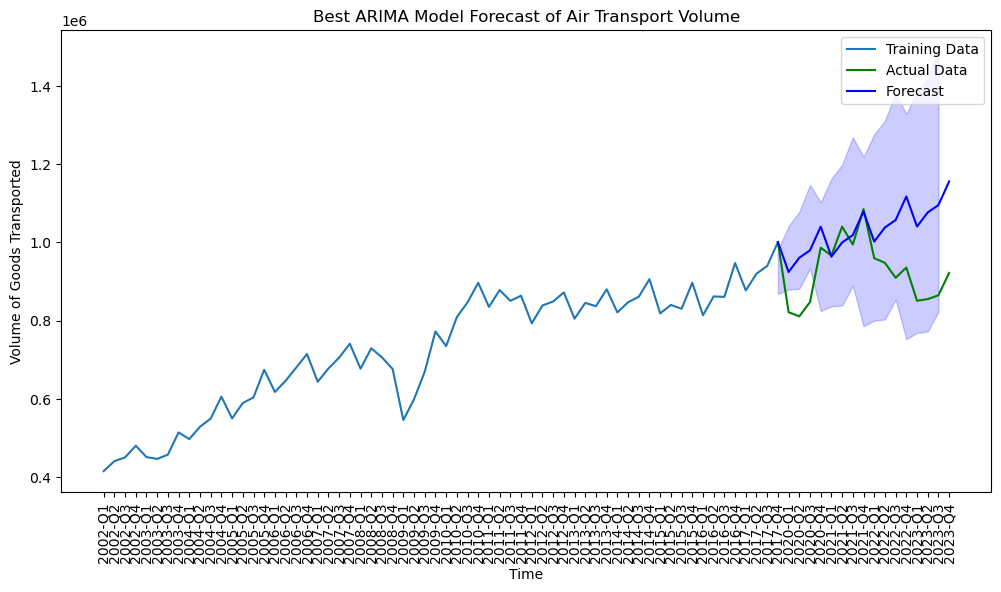

In [13]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train_array, label='Training Data')
plt.plot(forecast_index, test_array, label='Actual Data', color='green')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='blue')
plt.fill_between(forecast_index[0:-1], forecast_ci['lower'], forecast_ci['upper'], color='blue', alpha=0.2)
plt.xlabel('Time')
plt.ylabel('Volume of Goods Transported')
plt.title('Best ARIMA Model Forecast of Air Transport Volume')
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [15]:
# Calculate yearly difference and cumulative sum
difference = test_array[1:] - forecast_mean[1:]  # Calculate yearly difference excluding first aligned value
difference_df = pd.DataFrame({'Year': forecast_index[1:], 'Difference': difference})
yearly_difference = difference_df.groupby('Year')['Difference'].sum()
cumulative_difference = yearly_difference.cumsum()

# Find the first year where cumulative difference is greater than 0 (indicating recovery)
recovery_year = cumulative_difference[cumulative_difference > 0].index.min()

# Display the cumulative difference and recovery information
print("Yearly Difference between Actual and Forecasted Values:")
print(yearly_difference)
print("\nCumulative Difference by Year:")
print(cumulative_difference)

if recovery_year:
    print(f"The transport volume is considered to have recovered by the year {recovery_year}.")
else:
    print("The transport volume has not shown recovery within the forecast period.")

Yearly Difference between Actual and Forecasted Values:
Year
2020-Q1   -102622.249650
2020-Q2   -149831.918932
2020-Q3   -132269.847925
2020-Q4    -53802.735261
2021-Q1      2824.373372
2021-Q2     40515.476057
2021-Q3    -24074.377148
2021-Q4      6118.387458
2022-Q1    -42390.722006
2022-Q2    -90513.191601
2022-Q3   -147411.257427
2022-Q4   -181640.017567
2023-Q1   -189615.534601
2023-Q2   -221438.442527
2023-Q3   -230429.799582
2023-Q4   -233705.282391
Name: Difference, dtype: float64

Cumulative Difference by Year:
Year
2020-Q1   -1.026222e+05
2020-Q2   -2.524542e+05
2020-Q3   -3.847240e+05
2020-Q4   -4.385268e+05
2021-Q1   -4.357024e+05
2021-Q2   -3.951869e+05
2021-Q3   -4.192613e+05
2021-Q4   -4.131429e+05
2022-Q1   -4.555336e+05
2022-Q2   -5.460468e+05
2022-Q3   -6.934581e+05
2022-Q4   -8.750981e+05
2023-Q1   -1.064714e+06
2023-Q2   -1.286152e+06
2023-Q3   -1.516582e+06
2023-Q4   -1.750287e+06
Name: Difference, dtype: float64
The transport volume is considered to have recovered

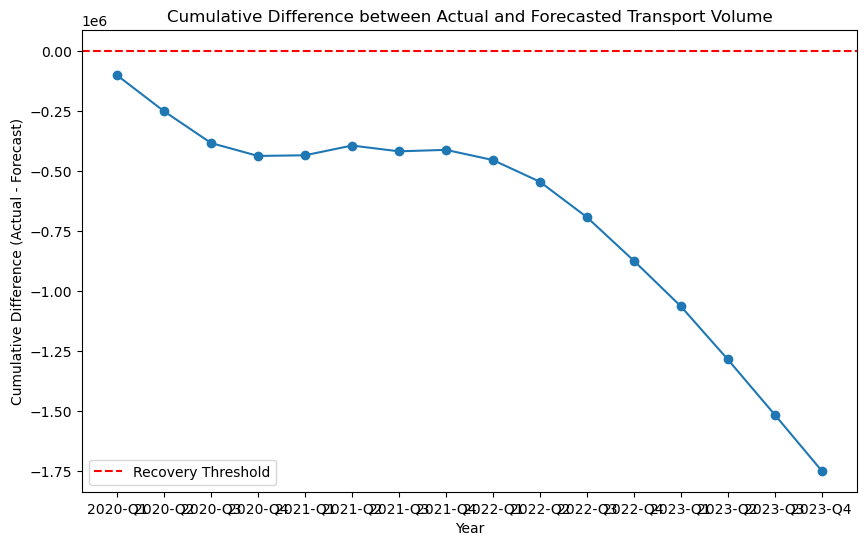

In [16]:
# Plot cumulative difference over years
plt.figure(figsize=(10, 6))
plt.plot(cumulative_difference.index, cumulative_difference.values, marker='o', linestyle='-')
plt.axhline(0, color='red', linestyle='--', label='Recovery Threshold')
plt.xlabel('Year')
plt.ylabel('Cumulative Difference (Actual - Forecast)')
plt.title('Cumulative Difference between Actual and Forecasted Transport Volume')
plt.legend()

plt.show()